<a href="https://colab.research.google.com/github/MichaelCondo/Team9-APS360-Project/blob/main/CheckYoSelf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check Yo' Self 
**Self-serve checkout enhancement using Neural Networks and Deep Learning**

## Architecture
![alt text](https://github.com/MichaelCondo/Team9-APS360-Project/blob/main/docs/Architecture_Diagram.png?raw=true)

#### Colab Link
https://colab.research.google.com/github/MichaelCondo/Team9-APS360-Project/blob/main/CheckYoSelf.ipynb

In [59]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Seed for reproducible results
np.random.seed(1000)
torch.manual_seed(1000)
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## 0. Helper Functions

## 1. Data Collection

**Tasks**:
* Understand Fruits 360 dataset
* Loading dataset into Colab
* Collecting prices of fruits
* Splitting the dataset into training, validation and testing (stratify or random) 

### 1.1 Fruits 360 Dataset

[Fruits 360](https://www.kaggle.com/moltean/fruits) is a dataset of 90000+ images of 130+ fruits and vegetables, in RGB colour at 100x100px a piece.

We're using [the GitHub mirror](https://github.com/Horea94/Fruit-Images-Dataset) to download the dataset as it does not require authentication to Kaggle.

In [60]:
# Download the dataset from GitHub
!wget -nc https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip \
    && mkdir -p "/root/project" \
    && unzip -nq "master.zip" -d "/root/project/datasets" \
    && find "/root/project/datasets/" -mindepth 2 -maxdepth 2 -type d -ls
DATA_MASTER_PATH = "/root/project/datasets/Fruit-Images-Dataset-master"

File ‘master.zip’ already there; not retrieving.

  1877231      4 drwxr-xr-x   2 root     root         4096 Sep  9 15:32 /root/project/datasets/Fruit-Images-Dataset-master/papers
  1841562      4 drwxr-xr-x 133 root     root         4096 Nov 11 04:43 /root/project/datasets/Fruit-Images-Dataset-master/Test
  1864382      4 drwxr-xr-x 133 root     root         4096 Nov 11 04:43 /root/project/datasets/Fruit-Images-Dataset-master/Training
  1877234      4 drwxr-xr-x   5 root     root         4096 Sep  9 15:32 /root/project/datasets/Fruit-Images-Dataset-master/src
  1877259      4 drwxr-xr-x   2 root     root         4096 Sep  9 15:32 /root/project/datasets/Fruit-Images-Dataset-master/test-multiple_fruits


Let's take a look at the contents of the dataset. 

- How many training and testing samples do we have? 
- How many training samples are there for each of the classes?

In [61]:
!echo "Training samples" && find "{DATA_MASTER_PATH}/Training" -type f | wc -l 
!echo "Testing samples" && find "{DATA_MASTER_PATH}/Test" -type f | wc -l 

!echo "Training samples class distribution" \
    && cd "{DATA_MASTER_PATH}/Training" \
    && find -maxdepth 2 -mindepth 2 -type f -printf "%h\0" \
    | uniq -zc | tr '\0' '\n' | sort -rh  \
    | (sed -u 10q ; echo "..." ; tail)

Training samples
67692
Testing samples
22688
Training samples class distribution
    984 ./Grape Blue
    900 ./Plum 3
    738 ./Tomato 3
    738 ./Tomato 1
    738 ./Strawberry Wedge
    738 ./Peach 2
    738 ./Melon Piel de Sapo
    738 ./Cherry Rainier
    738 ./Cherry 2
    735 ./Walnut
...
    438 ./Onion White
    429 ./Apple Red 3
    427 ./Avocado
    426 ./Mango Red
    420 ./Plum 2
    392 ./Cucumber Ripe
    367 ./Tomato Maroon
    300 ./Pear Kaiser
    300 ./Mangostan
    297 ./Ginger Root


### 1.2: Data Processing

Remove the folders that have items that are not sold individually, such as berries. Also, consolidate classes that feature the same type of fruit.

Michael: this is what the class consolidation looks like right now, everything else just maps the original to itself

```
New Class                       Old Classes(s)
Apple Red                       Apple Red 1, Apple Red 2, Apple Red 3
Apple Red Delicious             Apple Red Delicious
Apple Red Yellow                Apple Red Yellow
Apple Golden                    Apple Golden 1, 2, 3
Avocado                         Avocado, Avocado Ripe
Cantaloupe                      Cantaloupe 1, 2
Cucumber                        Cucumber Ripe 1, 2 (Look different though)
Onion Red                       Onion Red, Onion Red Peeled
Peach                           Peach 1, 2
Pear                            Pear 1, 2
Plum                            Plum 1, 2, 3
Tomato                          Tomato 1, 2, 3, 4 (Look different though)
```


In [62]:
"""
TODO: once we agree on this more or less, turn this into a JSON file that we
host in our GitHub repo and download so it doesn't take up so many lines in our 
notebook e.g. https://stackoverflow.com/a/12965254

This dict contains a mapping from the original class names to our new classes.

This will allow us to effectively consolidate classes that are similar looking
and would be treated similarly at a grocery store checkout.

We've also removed the classes that we don't want to train our model on such as
items that are not sold individually (e.g. small berries)
"""
CLASS_MAPPING = {
    "Apple Braeburn": "Apple Braeburn",
    "Apple Crimson Snow": "Apple Crimson Snow",
    "Apple Golden 1": "Apple Golden",
    "Apple Golden 2": "Apple Golden",
    "Apple Golden 3": "Apple Golden",
    "Apple Granny Smith": "Apple Granny Smith",
    "Apple Pink Lady": "Apple Pink Lady",
    "Apple Red 1": "Apple Red",
    "Apple Red 2": "Apple Red",
    "Apple Red 3": "Apple Red",
    "Apple Red Delicious": "Apple Red Delicious",
    "Apple Red Yellow 1": "Apple Red Yellow 1",
    "Apple Red Yellow 2": "Apple Red Yellow 2",
    "Apricot": "Apricot",
    "Avocado": "Avocado",
    "Avocado ripe": "Avocado",
    "Banana": "Banana",
    "Banana Lady Finger": "Banana Lady Finger",
    "Banana Red": "Banana Red",
    "Beetroot": "Beetroot",

    "Cactus fruit": "Cactus fruit",
    "Cantaloupe 1": "Cantaloupe",
    "Cantaloupe 2": "Cantaloupe",
    "Carambula": "Carambula",
    "Cauliflower": "Cauliflower",
    
    "Clementine": "Clementine",
    "Cocos": "Cocos",
    "Corn": "Corn",
    "Corn Husk": "Corn Husk",
    "Cucumber Ripe": "Cucumber Ripe",
    "Cucumber Ripe 2": "Cucumber Ripe",
    "Dates": "Dates",
    "Eggplant": "Eggplant",
    "Fig": "Fig",
    "Ginger Root": "Ginger Root",
    "Granadilla": "Granadilla",

    "Grapefruit Pink": "Grapefruit Pink",
    "Grapefruit White": "Grapefruit White",
    "Guava": "Guava",

    "Kaki": "Kaki",
    "Kiwi": "Kiwi",
    "Kohlrabi": "Kohlrabi",
    "Kumquats": "Kumquats",
    "Lemon": "Lemon",
    "Lemon Meyer": "Lemon Meyer",
    "Limes": "Limes",
    "Lychee": "Lychee",
    "Mandarine": "Mandarine",
    "Mango": "Mango",
    "Mango Red": "Mango Red",
    "Mangostan": "Mangostan",
    "Maracuja": "Maracuja",
    "Melon Piel de Sapo": "Melon Piel de Sapo",

    "Nectarine": "Nectarine",
    "Nectarine Flat": "Nectarine Flat",

    "Onion Red": "Onion Red",
    "Onion Red Peeled": "Onion Red",
    "Onion White": "Onion White",
    "Orange": "Orange",
    "Papaya": "Papaya",
    "Passion Fruit": "Passion Fruit",
    "Peach": "Peach",
    "Peach 2": "Peach",
    "Peach Flat": "Peach Flat",
    "Pear": "Pear",
    "Pear 2": "Pear",
    "Pear Abate": "Pear Abate",
    "Pear Forelle": "Pear Forelle",
    "Pear Kaiser": "Pear Kaiser",
    "Pear Monster": "Pear Monster",
    "Pear Red": "Pear Red",
    "Pear Stone": "Pear Stone",
    "Pear Williams": "Pear Williams",
    "Pepino": "Pepino",
    "Pepper Green": "Pepper Green",
    "Pepper Orange": "Pepper Orange",
    "Pepper Red": "Pepper Red",
    "Pepper Yellow": "Pepper Yellow",
    "Physalis": "Physalis",
    "Physalis with Husk": "Physalis with Husk",
    "Pineapple": "Pineapple",
    "Pineapple Mini": "Pineapple Mini",
    "Pitahaya Red": "Pitahaya Red",
    "Plum": "Plum",
    "Plum 2": "Plum",
    "Plum 3": "Plum",
    "Pomegranate": "Pomegranate",
    "Pomelo Sweetie": "Pomelo Sweetie",
    "Potato Red": "Potato Red",
    "Potato Red Washed": "Potato Red Washed",
    "Potato Sweet": "Potato Sweet",
    "Potato White": "Potato White",
    "Quince": "Quince",
    "Rambutan": "Rambutan",
    
    "Salak": "Salak",
    
    "Tamarillo": "Tamarillo",
    "Tangelo": "Tangelo",
    "Tomato 1": "Tomato",
    "Tomato 2": "Tomato",
    "Tomato 3": "Tomato",
    "Tomato 4": "Tomato",
    "Tomato Cherry Red": "Tomato Cherry Red",
    "Tomato Heart": "Tomato Heart",
    "Tomato Maroon": "Tomato Maroon",
    "Tomato not Ripened": "Tomato not Ripened",
    "Tomato Yellow": "Tomato Yellow",
    
    "Watermelon": "Watermelon"
}

In [63]:
import os
import shutil

for dataset_type in ["Training", "Test"]:
    for f in os.scandir(f"{DATA_MASTER_PATH}/{dataset_type}"):
        if f.is_dir() and f.name not in CLASS_MAPPING:
            shutil.rmtree(f.path)
            print("Removed", dataset_type, "/", f.name)

Removed Training / Grape Pink
Removed Training / Cherry Wax Black
Removed Training / Cherry Wax Red
Removed Training / Cherry 1
Removed Training / Walnut
Removed Training / Hazelnut
Removed Training / Grape White 4
Removed Training / Grape Blue
Removed Training / Nut Pecan
Removed Training / Cherry 2
Removed Training / Mulberry
Removed Training / Blueberry
Removed Training / Cherry Wax Yellow
Removed Training / Cherry Rainier
Removed Training / Strawberry Wedge
Removed Training / Grape White
Removed Training / Nut Forest
Removed Training / Strawberry
Removed Training / Chestnut
Removed Training / Grape White 2
Removed Training / Huckleberry
Removed Training / Redcurrant
Removed Training / Grape White 3
Removed Training / Raspberry
Removed Test / Grape Pink
Removed Test / Cherry Wax Black
Removed Test / Cherry Wax Red
Removed Test / Cherry 1
Removed Test / Walnut
Removed Test / Hazelnut
Removed Test / Grape White 4
Removed Test / Grape Blue
Removed Test / Nut Pecan
Removed Test / Cherry

In [64]:
!cd "{DATA_MASTER_PATH}/Training" \
    && find -maxdepth 2 -mindepth 2 -type f -printf "%h\0" \
    | uniq -zc | tr '\0' '\n' | sort -rh  \
    | (sed -u 10q ; echo "..." ; tail)

    900 ./Plum 3
    738 ./Tomato 3
    738 ./Tomato 1
    738 ./Peach 2
    738 ./Melon Piel de Sapo
    711 ./Pear Stone
    702 ./Pepper Orange
    702 ./Pear Forelle
    702 ./Fig
    702 ./Cauliflower
...
    438 ./Onion White
    429 ./Apple Red 3
    427 ./Avocado
    426 ./Mango Red
    420 ./Plum 2
    392 ./Cucumber Ripe
    367 ./Tomato Maroon
    300 ./Pear Kaiser
    300 ./Mangostan
    297 ./Ginger Root


### 1.3: Data loading

Now we'll create Pytorch dataloaders for our train, validation, and test sets

In [65]:
class RemappedImageFolder(torchvision.datasets.ImageFolder):
    """Subclass of ImageFolder that lets you remap your classes at parse time
    instead of through target_transform (which would be applied on every getitem)
    """
    def __init__(self, class_remapping, **kwargs):
        self.class_remapping = class_remapping
        super(RemappedImageFolder, self).__init__(**kwargs)


    def _find_classes(self, dir):
        """Override ImageFolder's class identification method so we can 
        do custom consolidation of our classes.
        See https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
        """
        # Get the original classes (i.e. folder names)
        o_classes = super()._find_classes(dir)[0]
        
        # Get our classes (from the JSON mapping)
        classes = list(sorted(set(self.class_remapping.values())))
    
        # Create an index for only our new classes 
        new_class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        
        # Map the old classes to their indices in our new system
        real_class_to_idx = {
            old_class: new_class_to_idx[self.class_remapping[old_class]]
            for old_class in o_classes
        }

        return classes, real_class_to_idx

In [66]:
from sklearn.model_selection import train_test_split

def get_data_loaders(batch_size=1):
    """Loads images of produce, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch (<1 means 
        use the full dataset in every batch)
    
    Returns:
        train_loader: iterable training dataset (from training data)
        val_loader: iterable validation dataset (from training data)
        test_loader: iterable testing dataset (from test data)
        classes: A list of strings denoting the name of each class
    """
    ########################################################################
    # We'll return a (train, val, test, classes) tuple
    classes = list(sorted(set(CLASS_MAPPING.values())))

    # Load datasets
    train_set, test_set = [
        RemappedImageFolder(
            class_remapping=CLASS_MAPPING,
            root=f"{DATA_MASTER_PATH}/{kind}",
            transform=transforms.Compose(
                [transforms.Resize((100, 100)), transforms.ToTensor()]
            ),
        )
        for kind in ("Training", "Test")
    ]

    # Split train/validation data with stratification of classes
    train_idx, val_idx = train_test_split(
        np.arange(len(train_set.targets)),
        test_size=0.3,
        shuffle=True,
        stratify=train_set.targets
    )

    train_set, val_set = [
        torch.utils.data.Subset(train_set, idx)
        for idx in [train_idx, val_idx]
    ]

    # Create and return the data loaders
    bs = len(train_set) if batch_size < 1 else batch_size
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=bs, num_workers=1, shuffle=True
    )
    
    bs = len(val_set) if batch_size < 1 else batch_size
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=bs, num_workers=1, shuffle=True
    )
    
    bs = len(test_set) if batch_size < 1 else batch_size
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=bs, num_workers=1, shuffle=True
    )

    return train_loader, val_loader, test_loader, classes

Found 38035 Training examples
Found 16301 Validation examples
Found 18215 Test examples
There are 92 classes
Training set looks like:


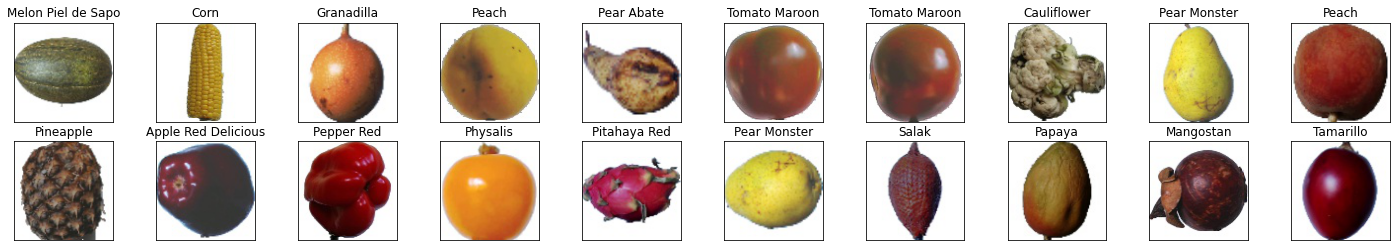

In [69]:
# Count the samples
for kind, loader in zip(["Training", "Validation", "Test"], get_data_loaders()[:3]):
    print(f"Found {len(loader)} {kind} examples")

# Prepare dataloaders for real
train_loader, val_loader, test_loader, classes = get_data_loaders(
    batch_size=27  # we know that this is a divisor of the number of submissions
)

print("There are", len(classes), "classes")

print("Training set looks like:")
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## 2. Data Processing

**Tasks**:
* Remove items that are not sold as individual fruits (i.e. vegetables, small berries, bunched bananas)
* Consolidate split classes either by combining or removing (e.g. Apple Red 1/2/3)


## 3. Baseline Model

**Tasks**:
* Setup and train random forrest model


## 4. Model Setup

**Tasks**:
* Using previous labs as reference, create CNN skeleton to work for 100x100 RGB images


## 5. Model Training and Tuning

**Tasks**:
* Write training code 
* Adjust hyperparameters to get at least 90% validation accuracy

